In [151]:
from zipfile import ZipFile, Path
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster 

In [152]:
def get_data(path: str) -> pd.DataFrame:
    '''
    Get data from zip file
    '''
    with ZipFile(path) as myzip:
        data = myzip.open(path.split('.zip')[0])

    df = pd.read_csv(data, sep =';')
    return df

In [153]:
df_2021_2022 = get_data("DMR_2021_2022.csv.zip")
df_2020 = get_data("DMR_2020.csv.zip")
df_2019 = get_data("DMR_2019.csv.zip")

In [154]:
df_2021_2022[['X', 'Y']] = df_2021_2022['geo_point_2d'].str.split(',', expand=True)


In [155]:
df_2021_2022 = df_2021_2022.drop(['ID DECLARATION', 'VILLE', 'ANNEE DECLARATION', 'MOIS DECLARATION',
         'OUTIL SOURCE', 'ID_DMR', 'geo_shape', 'geo_point_2d', 'CONSEIL DE QUARTIER'], axis = 1)

In [156]:
df_2019_2020 = pd.concat([df_2019, df_2020])
df_2019_2020 = df_2019_2020.drop(['OBJECTID', 'ID_DMR', 'VILLE' ,'ANNEEDECL' ,'MOISDECL' ,'NUMERO','PREFIXE', 'CONSEILQUARTIER',  ], axis = 1)


In [157]:
df_2019_2020.rename(columns = {'TYPE':'TYPE DECLARATION', 'SOUSTYPE':'SOUS TYPE DECLARATION', 'CODE_POSTAL':'CODE POSTAL', 'DATEDECL':'DATE DECLARATION'}, inplace = True)
df_2019_2020.rename(columns = {'Y':'LONGITUDE', 'X':'LATITUDE'}, inplace = True)
df_2021_2022.rename(columns = {'X':'LONGITUDE', 'Y':'LATITUDE'}, inplace = True)
df_final = pd.concat([df_2021_2022, df_2019_2020])


In [158]:
df_final.head()

,TYPE DECLARATION,SOUS TYPE DECLARATION,ADRESSE,CODE POSTAL,ARRONDISSEMENT,DATE DECLARATION,INTERVENANT,LONGITUDE,LATITUDE
0,Mobiliers urbains,Collecte des déchets:Trilib' dégradé,"18 Rue de Mazagran, 75010 PARIS",75010,10,2021-01-08,TRILIB',48.8707730016144,2.352240998304316
1,Objets abandonnés,Autres objets encombrants abandonnés,"58 Rue de l'Aqueduc, 75010 PARIS",75010,10,2021-01-08,Ramen en tant que prestataire de DansMaRue,48.88284700351721,2.365264406238782
2,Objets abandonnés,Autres objets encombrants abandonnés,"106 Rue des Amandiers, 75020 PARIS",75020,20,2021-01-08,Ramen en tant que prestataire de DansMaRue,48.86777999827195,2.388730996327768
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","14 Rue Carrière-Mainguet, 75011 PARIS",75011,11,2021-01-08,graffitis,48.856599995660474,2.387607803079172
4,Objets abandonnés,Cartons,"1 Square Alfred Capus, 75016 PARIS",75016,16,2021-01-08,DPE-STPP-DT,48.85093700329557,2.259631402809926


In [159]:
arrondissement_count = df_final["ARRONDISSEMENT"].value_counts()

fig = px.bar(arrondissement_count, x=arrondissement_count.index, y='ARRONDISSEMENT',
             hover_data=[arrondissement_count.index, 'ARRONDISSEMENT'], color='ARRONDISSEMENT',
             labels={'index': "District number",'ARRONDISSEMENT':'District'}, height=400)
fig.update_xaxes(type='category')
fig.show()
# USE INDEX AS X AXIS

In [160]:

fig = px.pie(arrondissement_count, values='ARRONDISSEMENT',
            names=arrondissement_count.index, 
            title='Pie chart of anomalies by district',
            color='ARRONDISSEMENT',
            color_discrete_sequence=px.colors.cyclical.IceFire,
            labels={'index': "Number", 'ARRONDISSEMENT': 'Anomalies' }, height=400)
fig.update_layout(width=1000,
    height=700,
    legend_title_text='District'
)

fig.show()

In [161]:
df_final['LONGITUDE'] = df_final['LONGITUDE'].apply(lambda x: x.replace(',','.'))
df_final['LATITUDE'] =  df_final['LATITUDE'].apply(lambda x: x.replace(',','.'))


In [162]:

df_final['LONGITUDE'] = df_final['LONGITUDE'].astype(float)
df_final['LATITUDE'] = df_final['LATITUDE'].astype(float)
locations_x = df_final['LONGITUDE'].mean()
location_y = df_final['LATITUDE'].mean()

In [163]:
paris = folium.Map(location = [locations_x, location_y], tiles="Stamen Terrain",zoom_start = 12)
df_final_1000 = df_final.sample(1000)
marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)
for index, location_info in df_final_1000.iterrows():
    marker = folium.Marker([location_info["LONGITUDE"], location_info["LATITUDE"]])
    popup='Type: {}<br>Arrondisement: {} <br> Adresse: {} <br>  Date declaration {}'.format(
                                                            location_info["TYPE DECLARATION"], 
                                                            location_info["ARRONDISSEMENT"],
                                                            location_info["ADRESSE"],
                                                            location_info['DATE DECLARATION'])
    folium.Popup(popup, min_width=300, max_width=300).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(paris)

folium.LayerControl().add_to(paris)

paris

In [164]:
df_district = df_final.groupby(['ARRONDISSEMENT'], as_index=False).agg({'LONGITUDE': 'mean'
                                                                        , 'LATITUDE': 'mean'
                                                                        , 'TYPE DECLARATION': 'count'})
df_district['RATIO_ANOMALIES'] = df_district['TYPE DECLARATION'] / df_district['TYPE DECLARATION'].sum()
df_district['RATIO_ANOMALIES'] = df_district['RATIO_ANOMALIES'].multiply(7000).astype(int)
districts_map = folium.Map(location = [locations_x, location_y], tiles="Stamen Terrain",zoom_start = 13)

tooltip = "Click me!"

for index, location_info in df_district.iterrows():
    circle = folium.Circle(
    location=[location_info["LONGITUDE"], location_info["LATITUDE"]],
    radius=location_info["RATIO_ANOMALIES"],
    color="#3186cc",
    popup='District: {} <br> Anomalies: {}<br> '.format(
                                                            int(location_info["ARRONDISSEMENT"]),
                                                            int(location_info["TYPE DECLARATION"]), 
                                                            ),
    fill=True,
    tooltip=tooltip,
    fill_color="#3186cc",
)
    circle.add_to(districts_map)


folium.LayerControl().add_to(districts_map)
districts_map

In [165]:
df_final['TYPE DECLARATION'].replace(['Autos, motos, vélos... '],'Autos, motos, vélos...',inplace = True)

df_count_type = df_final['TYPE DECLARATION'].value_counts()

fig = px.histogram(df_count_type, y = df_count_type.index, x = 'TYPE DECLARATION',
            color='TYPE DECLARATION',
            width=1200, height=500,
            orientation='h',
            title='Histogram of anomalies by type',
            labels = {'index': 'Type', 'TYPE DECLARATION': 'Total'},)
fig.show()

In [166]:

df_count_sous_type_20 = df_final['SOUS TYPE DECLARATION'].value_counts()
# without the first row because it has like 4000 k counted value
df_count_sous_type_20 = df_count_sous_type_20[1:20]
fig = px.bar(df_count_sous_type_20, y = df_count_sous_type_20.index, x = 'SOUS TYPE DECLARATION',
            color='SOUS TYPE DECLARATION',
            width=1200, height=600,
            title='Histogram of sub types of declaration',
            orientation='h',
            labels = {'index': 'Type', 'SOUS TYPE DECLARATION': 'Total'},)
fig.show()

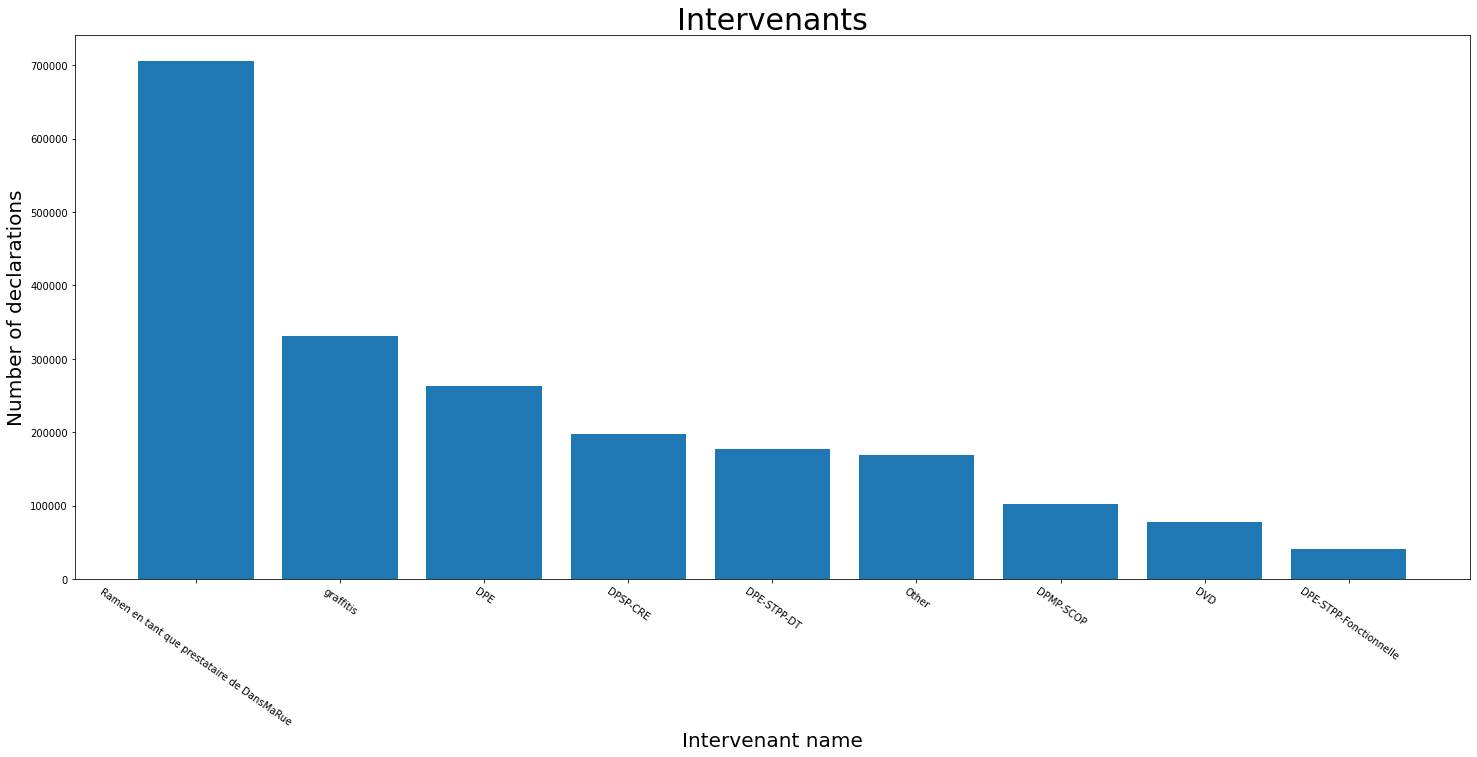

In [167]:
df_final['DATE DECLARATION'] = pd.to_datetime(df_final['DATE DECLARATION'],
                                                infer_datetime_format = True,
                                                dayfirst = True)
df_intervenants = df_final.groupby(['INTERVENANT'])['TYPE DECLARATION'].count().sort_values(ascending = False)
df_intervenants['Other'] = df_intervenants[8:].sum()
df_intervenants = df_intervenants.sort_values(ascending=False)
df_intervenants = df_intervenants[:9]

plt.figure(figsize=(25,10))
plt.title('Intervenants', size=30)
plt.xlabel('Intervenant name', size=20)
plt.ylabel('Number of declarations', size=20)
plt.xticks(rotation=-35)

plt.bar(x= df_intervenants.index, height=df_intervenants.values)

plt.show()


<AxesSubplot:title={'center':'Devices'}, xlabel='OUTIL SOURCE', ylabel='Number of declarations'>

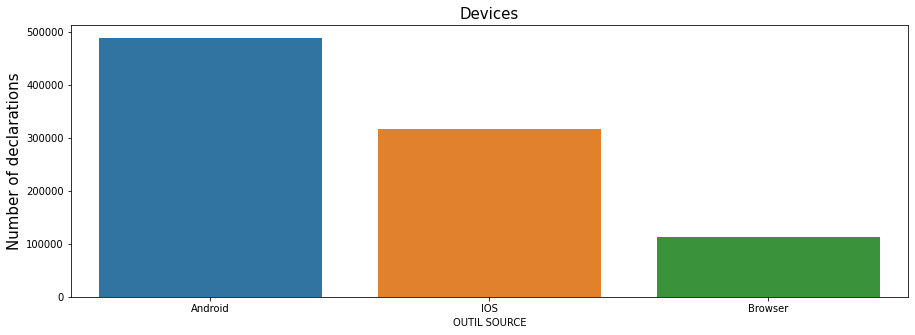

In [168]:
df_2021_2022 = get_data('DMR_2021_2022.csv.zip')
devices = df_2021_2022.groupby('OUTIL SOURCE')['OUTIL SOURCE'].count()
devices.drop('Back Office', inplace = True)
devices.rename({'Androï': 'Android','IOPage DMR Paris.fr application': 'IOS', 'Page DMR Paris.fr': 'Browser' }, inplace = True)
plt.figure(figsize=(15,5))
plt.title('Devices', size=15)
plt.xlabel('Device name', size=10)
plt.ylabel('Number of declarations', size=15)
sns.barplot(x=devices.index, y=devices.values, )

<AxesSubplot:title={'center':'Correlation matrix'}>

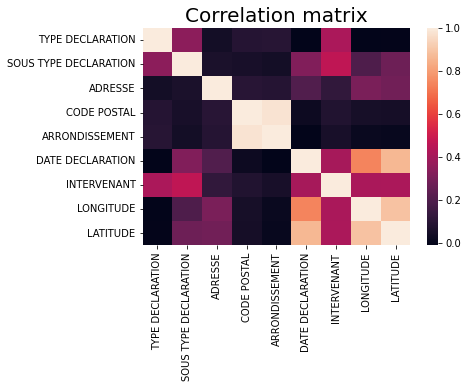

In [169]:
df_pearson_matrix = df_final.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.title('Correlation matrix', size=20)

sns.heatmap(df_pearson_matrix)

In [170]:
df_meteo = pd.read_csv('ECA_blended_custom/TG_STAID011249.txt',comment='#')
df_meteo.columns = df_meteo.columns.str.replace(' ', '')

df_meteo['TG']=df_meteo['TG']/10
df_meteo=df_meteo[df_meteo['TG'] > -273.15]
df_meteo.drop(['SOUID', 'Q_TG'], axis=1, inplace=True)
df_meteo.index=pd.to_datetime(df_meteo['DATE'],format="%Y%m%d")
df_meteo.drop('DATE', axis=1,inplace=True)
df_meteo = df_meteo['1949':]
df_meteo.head()

,TG
DATE,
1949-01-01,6.5
1949-01-02,4.6
1949-01-03,2.8
1949-01-04,3.6
1949-01-05,7.2


<AxesSubplot:xlabel='DATE'>

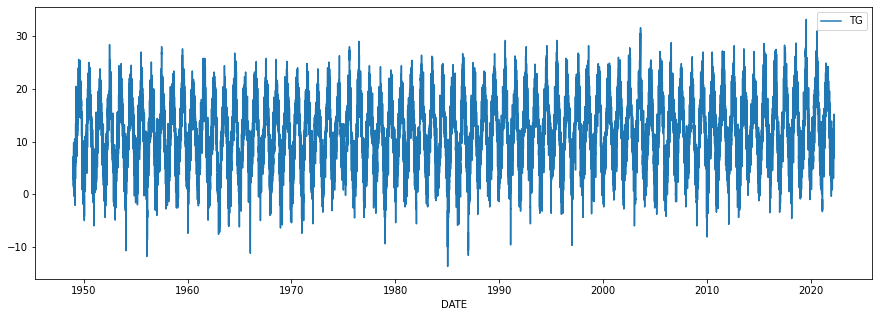

In [171]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_meteo)


<AxesSubplot:xlabel='DATE'>

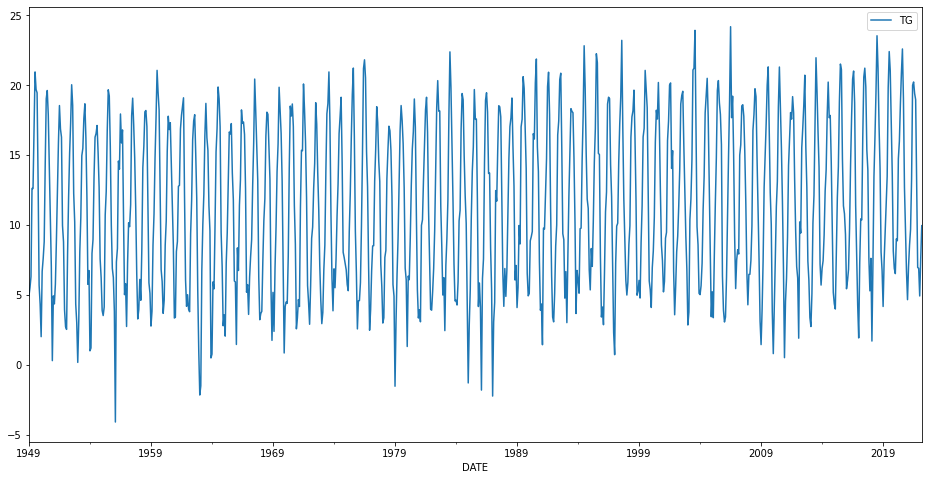

In [172]:
df_meteo_monthly = df_meteo.resample("M").mean()
df_meteo_monthly.plot(figsize=(16,8))

In [173]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(x=df_meteo['TG'])
print('pvalue:',adf[1])
print('adf:',adf[0])
print('usedlag:',adf[2])
print('nobs:',adf[3])
print('critical_values:',adf[4])
print('icbest:',adf[5])
# The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.


pvalue: 1.2555960183903574e-23
adf: -12.669145769882665
usedlag: 49
nobs: 26703
critical_values: {'1%': -3.430594913632547, '5%': -2.8616482447146434, '10%': -2.5668276154437395}
icbest: 116550.59098538576


In [174]:
data =[go.Scatter(x=df_meteo.index,y=df_meteo['TG'],name='Averagte Temperature-Daily',marker=dict(color='grey')),
        go.Scatter(x= df_meteo_monthly.index,y=df_meteo_monthly['TG'],name='AvgTemperature-Monthly',marker=dict(color='red'))
        ]
fig = go.Figure(data)

buttons = [dict(label='Both',method='restyle',args=[{'visible':[True,True]}]),
           dict(label='Daily',method='restyle',args=[{'visible':[True,False]}]),
           dict(label='Monthly',method='restyle',args=[{'visible':[False,True]}])]

updatemenus=[dict(type="buttons",direction='down',buttons=buttons)]
fig.update_layout(updatemenus=updatemenus,title='Average Temperature - Daily and Monthly - Paris')

In [175]:
by_season = df_meteo_monthly
SEASONS = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

MONTHS = {month: season for season in SEASONS.keys()
                        for month in SEASONS[season]
                        }
df_meteo_monthly['Season'] = df_meteo_monthly.index.month.map(MONTHS)
df_meteo_grouped_by_season = df_meteo_monthly.groupby([df_meteo_monthly.index.year,'Season'])['TG'].mean()
df_meteo_grouped_by_season = df_meteo_grouped_by_season.to_frame().unstack()


In [176]:
def plot_graph(df, title, xlabel, ylabel, markersize=5):
    df.plot(figsize=(16,8),
                                    legend=True,
                                    grid=True,
                                    fontsize=15,
                                    linewidth=2,
                                    marker='o',
                                    markersize=markersize,
                                    )      
    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=16)
    plt.title(title, fontsize=20)

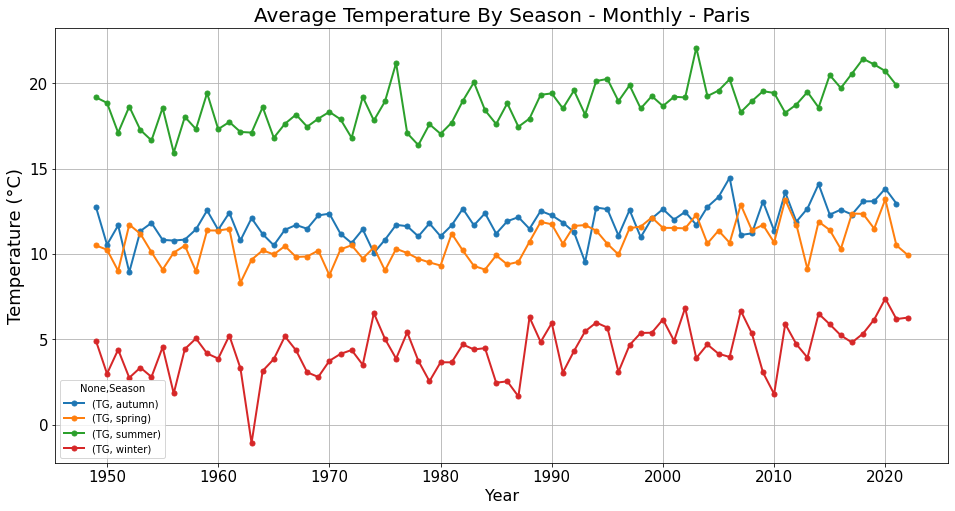

In [177]:
plot_graph(df_meteo_grouped_by_season, 'Average Temperature By Season - Monthly - Paris', 'Year', 'Temperature (°C)')

In [178]:
def _linfit(df :DataFrame) -> Series:
    """
    Calculates the linear fit for a given season
    
    :param df: DataFrame with the temperature data
    :type df: DataFrame
    :return: Linear fit for the given season
    """    
    df.dropna(axis=0,inplace=True)

    for season in SEASONS.keys():
        linfit = np.polyfit(df.index,df[season].values,deg=1)
        linfit = linfit[0]*df.index + linfit[1]
        _append_linfit(df, season, linfit)
        
    return linfit

def _append_linfit(df :DataFrame ,season : str, linfit : Series) -> DataFrame:
    """
    Appends the linear fit to the DataFrame
    
    :param df: DataFrame with the temperature data
    :type df: DataFrame
    :return: DataFrame with the linear fit
    """
    df['linfit_'+season] = linfit
    return df

def _linfit_all_seasons(df :DataFrame) -> DataFrame:
    """
    Calculates the mean of the linear fit of all seasons and appends it to the DataFrame
    
    :param df: DataFrame with the temperature data
    :type df: DataFrame
    :return: DataFrame with the linear fit
    """
    
    df['linear_fit_mean'] = df[['linfit_winter', 'linfit_spring', 'linfit_autumn', 'linfit_summer']].mean(axis=1)
    df.drop(['linfit_winter', 'linfit_spring', 'linfit_autumn', 'linfit_summer'], axis=1, inplace=True)
    return df


def _yearly_difference_celsius(): 
    """
    _yearly_difference_celsius calculates the yearly difference in temperature 
    between of the the mean of [1950:1965] and the yearly mean of every year in the dataframe

    :return: _description_
    :rtype: _type_
    """
    temp_mean_season = df_meteo_grouped_by_season.loc[1950:1965].mean()
    temperature = df_meteo_grouped_by_season.loc[1966:]['TG']
    mean_temps_season = {}
    for season in temp_mean_season.index:
        mean_temps_season[f'{season[1]}_mean'] =  temp_mean_season[season]
        temperature[season[1]] = temperature[season[1]] - temp_mean_season[season]
    return temperature

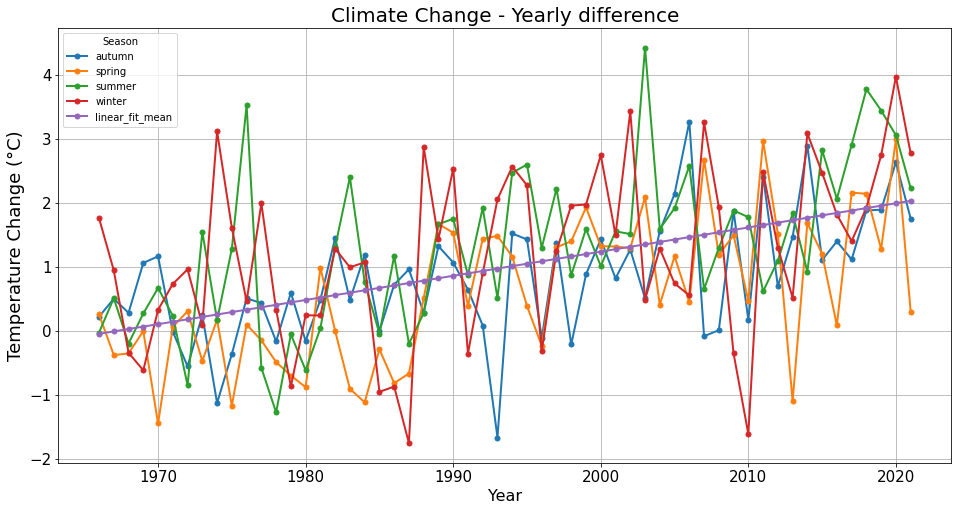

In [179]:
climate_change = _yearly_difference_celsius()
_linfit(climate_change)
_linfit_all_seasons(climate_change)
plot_graph(climate_change,'Climate Change - Yearly difference','Year','Temperature Change (°C)')


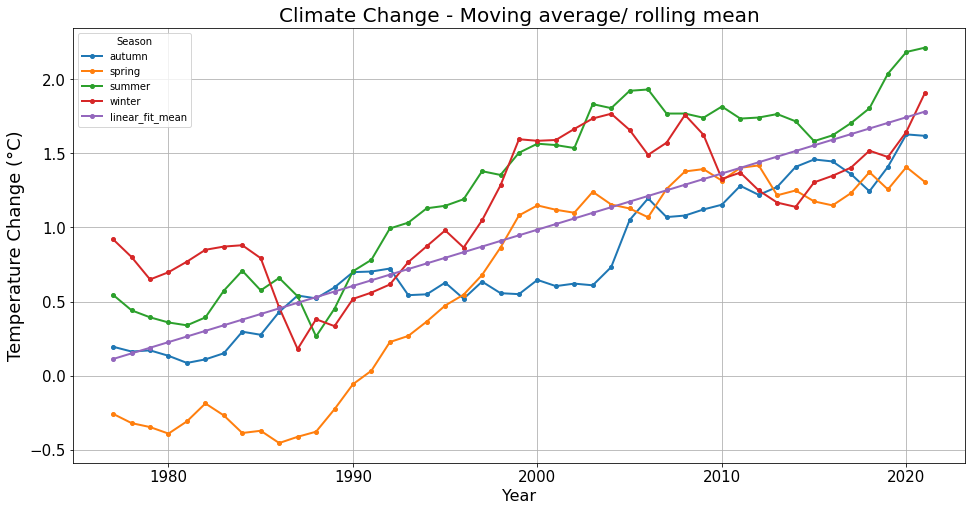

In [180]:
climate_change_rolling_mean = climate_change.rolling(window=12).mean()
_linfit(climate_change_rolling_mean)
_linfit_all_seasons(climate_change_rolling_mean)
plot_graph(climate_change_rolling_mean,'Climate Change - Moving average/ rolling mean','Year','Temperature Change (°C)', markersize=4)


In [181]:
print(df_meteo)
df_final['DATE DECLARATION']


              TG
DATE            
1949-01-01   6.5
1949-01-02   4.6
1949-01-03   2.8
1949-01-04   3.6
1949-01-05   7.2
...          ...
2022-03-27  14.5
2022-03-28  13.6
2022-03-29  15.2
2022-03-30  11.7
2022-03-31   6.9

[26753 rows x 1 columns]


0        2021-01-08
1        2021-01-08
2        2021-01-08
3        2021-01-08
4        2021-01-08
            ...    
586265   2020-12-31
586266   2020-12-31
586267   2020-12-31
586268   2020-12-31
586269   2020-12-31
Name: DATE DECLARATION, Length: 2066366, dtype: datetime64[ns]

In [182]:
# Merge the databases
df_meteo.reset_index(inplace=True)
df_final.rename(columns={'DATE DECLARATION':'DATE'},inplace=True)
df_merged = pd.merge(df_final, df_meteo, on=['DATE'])

<AxesSubplot:title={'center':'Correlation matrix'}>

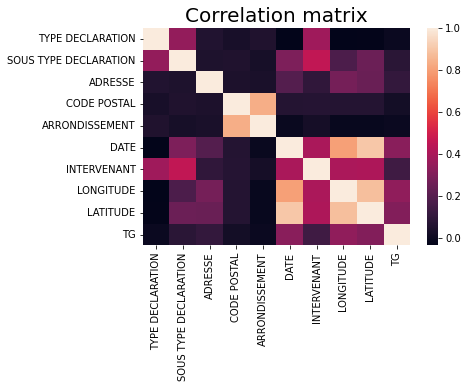

In [192]:
df_pearson_merged = df_merged.loc[20020:].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
plt.title('Correlation matrix', size=20)

sns.heatmap(df_pearson_merged)